# Trouver les bonnes manoeuvres pour arriver à un endroit donné avec un angle donné

![alt text](logo.png "Title")

Avec du A* (algorithme de recherche dans un arbre), et une heuristique qui prends la plus grande de ces deux deux bornes comme distance minimale restant à parcourir :
 - Il reste à parcourir au moins la distance qui nous sépare du point objectif
 - Il reste à parcourir au moins la distance qui, avec le rayon de braquage donné, permet de faire la différence d'angle voulue

Le  robot part du point 0,0, avec un angle 0 (axe des x), et veut aller à un autre PointAngle.
Je veux tout passer le plus possible en fonction, le moins possible en paramètres globaux

D'abord, les fonctions élémentaires pour faire les manoeuvres :

In [5]:
import math

def rotation(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)   + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return  (xr, yr)

In [63]:
# des tests
print(rotation(0,0,0,1,math.pi))
print(rotation(0,2,3,1,-math.pi))
print(rotation(0,2,0,2, math.pi/4))
print(rotation(-1,0,0,1,math.pi/2))

(1.2246467991473532e-16, 2.0)
(6.0, 3.3306690738754696e-16)
(0.0, 2.0)
(0.9999999999999999, 0.0)


In [289]:
# en français pour Xavier !

import math

AVANCE = 0
RECULE = 1
AVANT_DROIT = 2
AVANT_GAUCHE = 3
ARRIERE_DROIT = 4
ARRIERE_GAUCHE = 5
STARTING = 6

MANOEUVRES_TEXTE = ["AVANCE","RECULE","AVANT_DROIT","AVANT_GAUCHE","ARRIERE_DROIT","ARRIERE_GAUCHE","STARTING"]
COULEURS = ['tab:blue', 'tab:orange', "tab:green", 'tab:red', 'tab:purple', 'tab:brown', 'k'] # couleurs des flèches

# pour fonction "tresProche". Si < epsilon, les points sont considérés comme étant confondus
epsilonMetres = 0.05
epsilonRad = 0.08726646259971647    # 5 degrés


class PointAngle:
    # k => noir
    def __init__(self, x, y, angleRad, distanceParcourue = 0, pere = None, couleur = STARTING):
        self.x = x
        self.y = y
        if angleRad <= -math.pi:
            self.angleRad = angleRad + 2.0*math.pi
        elif angleRad > math.pi:
            self.angleRad = angleRad - 2.0 * math.pi
        else:
            self.angleRad = angleRad
        self.distanceParcourue = distanceParcourue
        self.pere = pere
        self.couleur = couleur
        self.estimation = 0  # renseignée par l'algo A*
    def __str__(self):
        return 'x : ' + str(self.x) + ', y : ' + str(self.y) + ', angle : ' + str(self.angleRad * 180/math.pi) + 'deg'

    def vecteurAngle(self):
        return (math.cos(self.angleRad), math.sin(self.angleRad))

    def vecteurAngleDroite(self):
        v = self.vecteurAngle()
        return (v[1], -v[0])

    def vecteurAngleGauche(self):
        v = self.vecteurAngle()
        return (-v[1], v[0])

    def avance(self, pas):
        xFils = self.x + self.vecteurAngle()[0] * pas
        yFils = self.y + self.vecteurAngle()[1] * pas
        return PointAngle(xFils, yFils, self.angleRad, self.distanceParcourue + pas, self, AVANCE)
    
    def recule(self, pas):
        xFils = self.x - self.vecteurAngle()[0] * pas
        yFils = self.y - self.vecteurAngle()[1] * pas
        return PointAngle(xFils, yFils, self.angleRad, self.distanceParcourue + pas, self, RECULE)

    def avantDroit(self, pas, rayonBraquage):
        angleRotation = - pas / rayonBraquage # vers ma droite => sens horaire => anti sens trigo
        # droite : x,y => y, -x
        vecteurAngleDroite = self.vecteurAngleDroite()
        xCentre = self.x + rayonBraquage * vecteurAngleDroite[0]
        yCentre = self.y + rayonBraquage * vecteurAngleDroite[1]
        position = rotation(self.x, self.y, xCentre, yCentre, angleRotation)
        return PointAngle(position[0], position[1], self.angleRad + angleRotation, self.distanceParcourue + pas, self, AVANT_DROIT)
    
    def avantGauche(self, pas, rayonBraquage):
        angleRotation = pas / rayonBraquage # vers ma gauche => trigo
        # droite : x,y => y, -x
        vecteurAngle = self.vecteurAngleGauche()
        xCentre = self.x + rayonBraquage * vecteurAngle[0]
        yCentre = self.y + rayonBraquage * vecteurAngle[1]
        position = rotation(self.x, self.y, xCentre, yCentre, angleRotation)
        return PointAngle(position[0], position[1], self.angleRad + angleRotation, self.distanceParcourue + pas, self, AVANT_GAUCHE)

        
    def arriereDroit(self, pas, rayonBraquage):
        angleRotation = pas / rayonBraquage # vers ma droite => sens horaire => anti sens trigo
        # droite : x,y => y, -x
        vecteurAngleDroite = self.vecteurAngleDroite()
        xCentre = self.x + rayonBraquage * vecteurAngleDroite[0]
        yCentre = self.y + rayonBraquage * vecteurAngleDroite[1]
        position = rotation(self.x, self.y, xCentre, yCentre, angleRotation)
        return PointAngle(position[0], position[1], self.angleRad + angleRotation, self.distanceParcourue + pas, self, ARRIERE_DROIT)

    def arriereGauche(self, pas, rayonBraquage):
        angleRotation = - pas / rayonBraquage
        # droite : x,y => y, -x
        vecteurAngle = self.vecteurAngleGauche()
        xCentre = self.x + rayonBraquage * vecteurAngle[0]
        yCentre = self.y + rayonBraquage * vecteurAngle[1]
        position = rotation(self.x, self.y, xCentre, yCentre, angleRotation)
        return PointAngle(position[0], position[1], self.angleRad + angleRotation, self.distanceParcourue + pas, self, ARRIERE_GAUCHE)
    
    def bouge(self, mouvement, pas, rayonBraquage, nombreDeFois = 1):
        if mouvement == AVANCE:
            resultat = self.avance(pas) 
        elif mouvement == RECULE:
            resultat = self.recule( pas)
        elif mouvement == AVANT_DROIT:
            resultat = self.avantDroit(pas, rayonBraquage)
        elif mouvement == AVANT_GAUCHE:
            resultat = self.avantGauche(pas, rayonBraquage)
        elif mouvement == ARRIERE_DROIT:
            resultat = self.arriereDroit(pas, rayonBraquage)
        elif mouvement == ARRIERE_GAUCHE:
            resultat = self.arriereGauche(pas, rayonBraquage)
        else:
            raise "mouvement inconnu"
        if nombreDeFois == 1:
            return resultat
        else:
            return resultat.bouge(mouvement, pas, rayonBraquage, nombreDeFois - 1)
    
    @staticmethod
    def mouvements():
        return (AVANCE,RECULE,AVANT_DROIT,AVANT_GAUCHE,ARRIERE_DROIT,ARRIERE_GAUCHE,)
    
    def couleurTexte(self):
        return COULEURS[self.couleur]
    
    def tresProche(self, p2):
        return abs(self.x - p2.x) < epsilonMetres and abs(self.y - p2.y) < epsilonMetres and abs(self.angleRad - p2.angleRad) < epsilonRad



# Test des mouvements

Je fais plusieurs manoeuvres d'affilée pour chaque mouvement, pour voir où ça arrive. La flèche est dans le sens de l'orientation du robot.
La couleur est différente pour chaque manoeuvre. Noir = position de départ

pointAngle final pour mouvement AVANCE
2.500000000000001 0.0 0.0 2.500000000000001
pointAngle final pour mouvement RECULE
-2.500000000000001 0.0 0.0 2.500000000000001
pointAngle final pour mouvement AVANT_DROIT
1.838556977300278 -1.4207211237489599 -75.38918356984517 2.500000000000001
pointAngle final pour mouvement AVANT_GAUCHE
1.838556977300278 1.4207211237489599 75.38918356984517 2.500000000000001
pointAngle final pour mouvement ARRIERE_DROIT
-1.838556977300278 -1.4207211237489599 75.38918356984517 2.500000000000001
pointAngle final pour mouvement ARRIERE_GAUCHE
-1.838556977300278 1.4207211237489599 -75.38918356984517 2.500000000000001


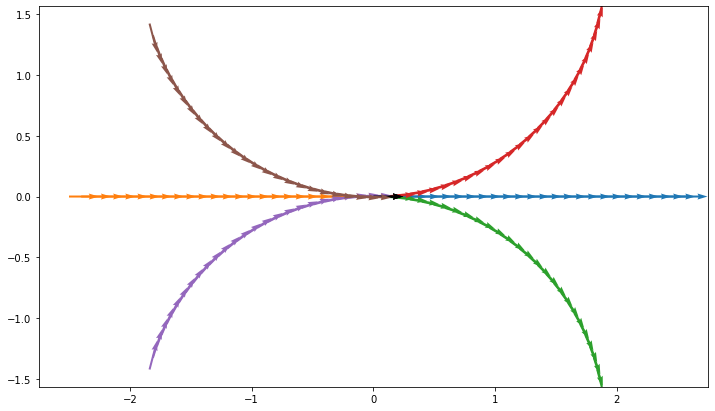

In [290]:
start = PointAngle(0,0,0)
pas = 0.1
rayonBraquage = 1.90
mouvements = PointAngle.mouvements()

pointsParMouvement = []
for mouvement in mouvements:
    plusieursMouvements = [start]
    for i in range(25):
        plusieursMouvements.append(plusieursMouvements[-1].bouge(mouvement, pas, rayonBraquage))
    print("pointAngle final pour mouvement " + MANOEUVRES_TEXTE[mouvement])
    dernier = plusieursMouvements[-1]
    print(dernier.x, dernier.y, dernier.angleRad * 180/math.pi, dernier.distanceParcourue)
    pointsParMouvement.append(plusieursMouvements)
    
import matplotlib.pyplot as plt
import numpy as np

pltX = []
pltY = []
pltU = []
pltV = []
pltCouleur = []

for (i, points) in enumerate(pointsParMouvement):
    for point in points:
        pltX.append(point.x)
        pltY.append(point.y)
        pltU.append(point.vecteurAngle()[0])
        pltV.append(point.vecteurAngle()[1])
        pltCouleur.append(point.couleurTexte() )

plt.figure(figsize=(12,12))
plt.gca().set_aspect('equal', adjustable='box')
plt.quiver(np.array(pltX), np.array(pltY), np.array(pltU), np.array(pltV), color = pltCouleur, width=0.003, )

# Algorithme A* avec les fonctions associées

In [296]:
# l'objectif est un carré, pas un cercle. Plus rapide à calculer si atteinte ou pas

def butAtteint(pointAngle, butPointAngle, toleranceXY, toleranceAngle):
    return (
    abs(pointAngle.x - butPointAngle.x) < toleranceXY 
and abs(pointAngle.y - butPointAngle.y) < toleranceXY
and diffAngle(pointAngle.angleRad, butPointAngle.angleRad) < toleranceAngle)

def distance(pa1, pa2):
    return ((pa1.x - pa2.x)**2 + (pa1.y - pa2.y)**2)**0.5

def distanceCarre(pa1, pa2):
    return (pa1.x - pa2.x)**2 + (pa1.y - pa2.y)**2

def diffAngle(a1, a2):
    a = a2 - a1
    if a > math.pi:
        a -= 2*math.pi
    elif a <= - math.pi:
        a += 2*math.pi
    return abs(a)

# https://stackoverflow.com/questions/1878907/the-smallest-difference-between-2-angles
def heuristiqueAngle(pointAngle, butPointAngle, rayonBraquage):
    # si je veux faire 2pi (un tour) et que mon rayon de braquage c'est 12,
    # alors je devrais faire le tour du cercle pour tourner, donc 2pi * 12
    # si je veux tourner de x radians, alors la distance c'est    x * rayonDeBraquage
    return rayonBraquage * diffAngle(pointAngle.angleRad, butPointAngle.angleRad)


def heuristique(pointAngle, butPointAngle, rayonBraquage):
    return max(distance(pointAngle, butPointAngle), heuristiqueAngle(pointAngle, butPointAngle, rayonBraquage) )


def meilleurCandidat(pointsAChercher, butPointAngle, rayonBraquage, fonctionHeuristique):
    # on sélectionne d'abord le pointAngle qui a la somme (distance déjà parcourue + estimation distance restante) la plus faible
    meilleureEstimation = 100000
    meilleurCandidat = None
    for pa in pointsAChercher :
        if pa.estimation != 0:
            estimation = pa.estimation
        else:
            estimation = pa.distanceParcourue + fonctionHeuristique(pa, butPointAngle, rayonBraquage)
            if pa.pere != None:
                # on empeche que l'heuristique diminue
                # j'aurai le max de tous mes ancetres.
                # si un de mes ancetre dit "tu fera pas mieux que 12" et j'estime que je ferai pas mieux que 10
                # je ferai quand même pas mieux que 12
                pa.estimation = max(estimation, pa.pere.estimation) 
        
        if estimation < meilleureEstimation:
            meilleureEstimation = estimation
            meilleurCandidat = pa
    return meilleurCandidat



def chercherMeilleureManoeuvre(butPointAngle,
                               fonctionButAtteint = butAtteint,
                               fonctionHeuristique = heuristique, 
                               pas = 0.2,
                               rayonBraquage = 1.90,
                               toleranceXY = pas * 1.4,
                               toleranceAngle = 30/180*math.pi,
                               limite = None,
                               log = False):
    pointsDejaCherchés = set()
    
    pointsAChercher = { PointAngle(0,0,0) }
    
    temps = 0 # pour savoir ce qui prends du temps, pas important pour l'algo
    
    nombre_iterations = 0
    
    while limite == None or nombre_iterations < limite:
        candidat = meilleurCandidat(pointsAChercher, butPointAngle, rayonBraquage, fonctionHeuristique)

        pointsAChercher.remove(candidat) # virer le candidat du set

        successeurs = [candidat.bouge(mouvement, pas, rayonBraquage) for mouvement in PointAngle.mouvements()]

        # on ajoute aussi les versions "nombreDeFois = 5", pour accélerer la recherche avec des "raccourcis" dans l'arbre
        successeurs.extend([candidat.bouge(mouvement, pas, rayonBraquage, 5) for mouvement in PointAngle.mouvements()])
        
        for successeur in successeurs:
            if fonctionButAtteint(successeur, butPointAngle, toleranceXY, toleranceAngle):
                print("trouvé !")
                return (successeur, nombre_iterations, pointsAChercher, pointsDejaCherchés, temps)
            else:
                mieuxDejaCherché = False
                debut = time.time()
                for dejaCherché in pointsDejaCherchés:
                    if successeur.tresProche(dejaCherché) and dejaCherché.distanceParcourue <= successeur.distanceParcourue:
                        mieuxDejaCherché = True
                        break
                if mieuxDejaCherché:
                    temps += (time.time() - debut)
                    if log: print('mieuxDejaCherché')
                else:
                    mieuxAChercher = False
                    for aChercher in pointsAChercher:
                        if successeur.tresProche(aChercher) and aChercher.distanceParcourue <= successeur.distanceParcourue:
                            mieuxAChercher = True
                            break
                    if mieuxAChercher:
                        temps += (time.time() - debut)
                        if log: print('mieuxAChercher')
                    else:
                        if log: print('bon candidat')
                        temps += (time.time() - debut)
                        pointsAChercher.add(successeur)

        pointsDejaCherchés.add(candidat)
        nombre_iterations += 1
    print("limite atteinte")
    return (None, nombre_iterations, pointsAChercher, pointsDejaCherchés, temps)

In [292]:

import matplotlib.pyplot as plt
import numpy as np


def afficherResultat(res, plusieurs = False):

    pltX = []
    pltY = []
    pltU = []
    pltV = []
    pltCouleur = []
    pltX.append(res.x)
    pltY.append(res.y)
    pltU.append(res.vecteurAngle()[0])
    pltV.append(res.vecteurAngle()[1])
    pltCouleur.append(res.couleurTexte())
    while res.pere != None:
        res = res.pere
        pltX.append(res.x)
        pltY.append(res.y)
        pltU.append(res.vecteurAngle()[0])
        pltV.append(res.vecteurAngle()[1])
        pltCouleur.append(res.couleurTexte())
    
    if not plusieurs:
        plt.figure(figsize=(15,15))
        plt.gca().set_aspect('equal', adjustable='box')
    plt.quiver(np.array(pltX), np.array(pltY), np.array(pltU), np.array(pltV), color = pltCouleur, width=0.003, )
    plt.show()

# Test de l'algorithme avec un PointAngle

trouvé !
1285
39.61025547981262
temps par iteration 30.825101540710214 ms
37.100653409957886
temps verification par iteration 28.8721038209789 ms
x : 1.8876073311820138, y : 1.1395002588739758, angle : -174.90290588204076deg


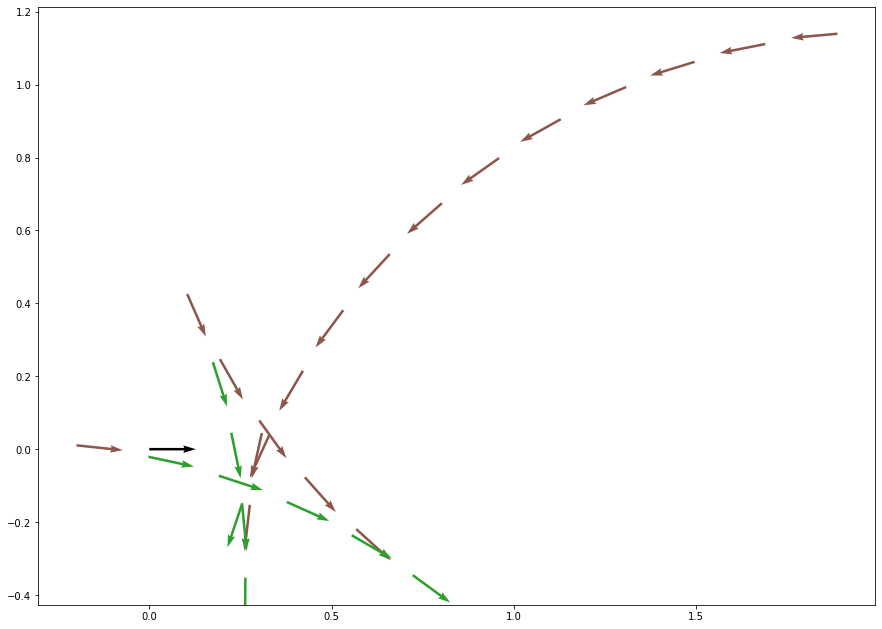

In [298]:
import time as time

debut = time.time()
(resultat, nombre_iterations, pointsAChercher, pointsDejaCherchés, temps) = chercherMeilleureManoeuvre(PointAngle(2, 1, -math.pi),
                               fonctionButAtteint = butAtteint,
                               fonctionHeuristique = heuristique, 
                               pas = 0.2,
                               rayonBraquage = 1.90,
                               toleranceXY = pas * 1.4,
                               toleranceAngle = 20/180*math.pi,
                               limite = 2000,
                               log = False)
fin = time.time()

print(nombre_iterations)
print( fin -debut)
print("temps par iteration " + str(  (fin - debut) / nombre_iterations * 1000) + " ms")
print(temps)
print("temps verification par iteration " + str(  temps / nombre_iterations * 1000) + " ms")
if resultat != None:
    print(resultat)
    afficherResultat(resultat)
else:
    plt.figure(figsize=(10,10))
    plt.gca().set_aspect('equal', adjustable='box')
    for pa in pointsDejaCherchés:
        afficherResultat(pa, plusieurs = True)

In [ ]:

def resumerManoeuvres(resultat):
    chaineDesPeres = []
    
    ancetre = resultat
    while ancetre.pere != None:
        chaineDesPeres.append(ancetre)
        ancetre = ancetre.pere
    # les vieux d'abord !
    chaineDesPeres.reverse()
    # pas = pere.distanceParcourue
    # list des manoeuvres avec (manoeuvre, distanceParcourue)
    chaineManoeuvres = [ (MANOEUVRES_TEXTE[chaineDesPeres[0].couleur], chaineDesPeres[0].distanceParcourue)]
    ancienneDistanceParcourue = chaineDesPeres[0].distanceParcourue
    chaineDesPeres.pop(0)
    
    
    for noeud in chaineDesPeres:
        pas = noeud.distanceParcourue - ancienneDistanceParcourue
        ancienneDistanceParcourue = noeud.distanceParcourue
        if chaineManoeuvres[-1][0] == MANOEUVRES_TEXTE[noeud.couleur]:
            chaineManoeuvres[-1] = (MANOEUVRES_TEXTE[noeud.couleur], chaineManoeuvres[-1][1] + pas )
        else:
            chaineManoeuvres.append( (MANOEUVRES_TEXTE[noeud.couleur], pas))
    return chaineManoeuvres

resumerManoeuvres(resultat)

# Générer une solution pour tout les points du plan, tout les angles

In [327]:

%matplotlib inline

def genererSolutionSurGrille(xMin, xMax, yMin, yMax, pasX, pasY, pasAngle):
    
    resumes = dict()
    x = xMin
    while x <= xMax:
        y = yMin
        while y <= yMax:
            angle = 0
            while angle < 2*math.pi:
                print("x : " + str(x) + ", y : " + str(y) + ", angle : " + str(angle * 180/math.pi) )
                (resultat, nombre_iterations, pointsAChercher, pointsDejaCherchés, temps) = chercherMeilleureManoeuvre(
                    PointAngle(x, y, angle),
                    fonctionButAtteint = butAtteint,
                    fonctionHeuristique = heuristique, 
                    pas = 0.2,
                    rayonBraquage = 1.90,
                    toleranceXY = pas * 1.4,
                    toleranceAngle = 20/180*math.pi,
                    limite = 1500,
                    log = False)
                if resultat != None:
                    #print("affichage")
                    #afficherResultat(resultat)
                    resume = resumerManoeuvres(resultat)
                    print(resume)
                    resumes[str(x) + ','+str(y)+str(angle)] = resume
                    #print(resumes)
                else:
                    print("pas de résultat assez rapide")
                angle += pasAngle
            y += pasY
        x += pasX
    return resumes

In [ ]:
resumes1 = genererSolutionSurGrille(-1.2, 1.2, -1.2, 1.2, 0.2, 0.2, math.pi/ 4)
print(resumes1)
resumes2 = genererSolutionSurGrille(-1.2, 1.2, -1.2, 1.2, 0.2, 0.2, math.pi/ 2)
print(resumes1)
print(resumes2)

x : -1.2, y : -1.2, angle : 0.0
limite atteinte
pas de résultat assez rapide
x : -1.2, y : -1.2, angle : 45.0
trouvé !
[('AVANT_GAUCHE', 0.4), ('ARRIERE_DROIT', 0.9999999999999999), ('RECULE', 1.0)]
x : -1.2, y : -1.2, angle : 90.0
trouvé !
[('ARRIERE_DROIT', 0.4), ('AVANT_GAUCHE', 0.4), ('ARRIERE_DROIT', 1.5999999999999999), ('RECULE', 0.20000000000000018)]
x : -1.2, y : -1.2, angle : 135.0
trouvé !
[('ARRIERE_DROIT', 2.4), ('AVANT_GAUCHE', 1.0000000000000009), ('ARRIERE_DROIT', 1.0000000000000004)]
x : -1.2, y : -1.2, angle : 180.0
trouvé !
[('ARRIERE_DROIT', 2.8000000000000003), ('AVANT_GAUCHE', 1.2000000000000006), ('ARRIERE_DROIT', 0.20000000000000018), ('AVANT_GAUCHE', 0.20000000000000018), ('ARRIERE_DROIT', 1.0000000000000009)]
x : -1.2, y : -1.2, angle : 225.0
trouvé !
[('ARRIERE_GAUCHE', 1.2), ('AVANT_DROIT', 0.9999999999999998), ('ARRIERE_GAUCHE', 0.40000000000000036), ('AVANT_DROIT', 0.20000000000000018), ('ARRIERE_GAUCHE', 0.20000000000000018), ('AVANT_DROIT', 1.40000000000

# Trouver des meilleurs heuristiques

Mon estimation de la distance est pourrie parce que la distance devant/ derrière le robot est très facile à parcourir, alors que se déplacer
sur sa droite / sur sa gauche de 40 centimètres par exemple va nécessiter des manoeuvres, donc beaucoup plus long

Dejà, ce serait bien de savoir si on est dans une zone accessible directement ou non. Les zones inaccessibles directement sont dans des cercles de rayon de braquage situées à ma droite et à ma gauche. Zones 5,6,7,8 sont inaccessibles

![alt text](zones.png "Title")

Si l'objectif (point O) n'est pas dans ces cercles, alors je peux y aller en longeant un des cercles jusqu'à un point T où la droite OT est tangeante avec le cercle. La distance à parcourir est alors \[OT\] + l'arc de cercle pour aller en T.

Si l'objectif est dans un cercle, alors soit il est plutôt devant moi, soit plutôt derrière moi.

In [68]:
def estAccessible(pointAngle, butPointAngle, rayonBraquage):
    vecteurAngleDroite = pointAngle.vecteurAngleDroite()
    xCentreDroit = pointAngle.x + rayonBraquage * vecteurAngleDroite[0]
    yCentreDroit = pointAngle.y + rayonBraquage * vecteurAngleDroite[1]
    
    distanceCarreDroit = (pointAngle.x - xCentreDroit)**2 + (pointAngle.y - yCentreDroit)**2
    
    vecteurAngleGauche = pointAngle.vecteurAngleGauche()
    xCentreGauche = pointAngle.x + rayonBraquage * vecteurAngleGauche[0]
    yCentreGauche = pointAngle.y + rayonBraquage * vecteurAngleGauche[1]
    
    distanceCarreGauche = (pointAngle.x - xCentreGauche)**2 + (pointAngle.y - yCentreGauche)**2
    
    return distanceCarreDroit >= rayonBraquage**2 and distanceCarreGauche >= rayonBraquage ** 2

# Changement de référentiel vers "référentiel de braquage"

Quel que soit la zone où l'on est, ça va beaucoup faciliter la suite de se mettre dans un référentiel où :
  - le robot est placé en (0,0) => translation par pointAngle
  - le robot est orienté vers l'axe des x => rotation par pointAngle.angleRad
  - les deux cercles de braquages sont de rayon 1 => on scale tout par rayon de braquage

# Symétries
Que l'on soit à gauche ou à droite, les opérations sont symétriques. De même, avant et arrière du robot sont symmétrique. On applique donc deux symmétries :
 - une symétrie axiale pour que le butPointAngle se retrouve toujours à gauche (désolé Xavier ;-) ) pour l'avoir dans les zones 1, 2, 5 ou6
 - une symétrie axiale pour que le butPointAngle se retrouve toujours devant le robot pour l'avoir dans les zones 2 et 6 uniquement
 
 On passe de 8 cas à 2 cas :
  - zone 2 : butPointAngle accessible
  - zone 6 : butPointAngle inaccessible
  
Mais vu que l'on cherche juste à calculer des distances ici, on n'aura pas besoin de faire la transformation dans l'ordre inverse (à part le scale des longueurs par rayon de braquage)

In [253]:
def tranformeButVersRefBraquage(pointAngle, butPointAngle, rayonBraquage):
    butPointAngleX = butPointAngle.x
    butPointAngleY = butPointAngle.y
    #translation
    butPointAngleX -= pointAngle.x
    butPointAngleY -= pointAngle.y
    # scale
    butPointAngleX /= rayonBraquage
    butPointAngleY /= rayonBraquage
    #rotation
    butPointAngleAngle = butPointAngle.angleRad - pointAngle.angleRad
    (butPointAngleX, butPointAngleY) = rotation(butPointAngleX, butPointAngleY, 0, 0, -pointAngle.angleRad)
    # symétrie gauche droite et symétrie avant arriere =>
    butPointAngleX = abs(butPointAngleX)
    butPointAngleY = abs(butPointAngleY)
    # butPointAngleAngle = butPointAngleAngle % (math.pi /2) # faux je pense. Les symétries en angle, pas important pour l'instant
    return (butPointAngleX, butPointAngleY)

x : 0.5, y : 0.49999999999999994, angle : 0.0deg


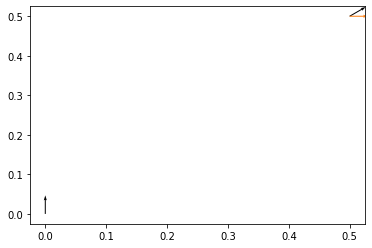

In [254]:
# test
depart = PointAngle(0, 0, math.pi / 2,     0, None, STARTING)
but = PointAngle(0.5, 0.5, 30/180*math.pi,            None, AVANCE) #bleu

butRefBraquageXY = tranformeButVersRefBraquage(depart, but, 1)
butRefBraquage = PointAngle(butRefBraquageXY[0], butRefBraquageXY[1], 0)
butRefBraquage.couleur = RECULE
print(butRefBraquage)
# hack pour afficher
depart.pere = but
but.pere = butRefBraquage
afficherResultat(depart, plusieurs = True)
# test ok !

# Si le point est à l'exterieur du cercle

Addition de deux longueurs, une en arc de cercle et un segment :
  - longueur arc de cercle = angle en radians car rayon 1
  - longueur du segment trouvable avec pythagore

![alt text](exterieur.png "Title")


In [301]:
# 

def heuristiqueMeilleureDistance(pointAngle, butPointAngle, rayonBraquage):
    (butX, butY) = tranformeButVersRefBraquage(pointAngle, butPointAngle, rayonBraquage)
    # avec la projection, on n'a plus que le cercle à ma gauche, de centre 0,1
    inaccessible = butX**2 + (butY - 1) **2 < 1 #pas besoin de racine, puisque rayon 1
    
    if inaccessible:
        #print("inaccessible")
        #dans le cercle, on peut calculer les manoeuvres
        distanceEstimee = distance(pointAngle, butPointAngle)
    else:
        #print("accessible")
        xL = butX
        yL = butY - 1
        longueurL = (xL**2 + yL **2) **0.5
        longueurSegment = (longueurL**2 - 1)**0.5
        #print(longueurSegment)

        angleL = math.atan2(yL, xL)
        angleTriangle = math.acos(1/longueurL)
        angle = angleL - angleTriangle + (math.pi /2)
        # correction scaling
        distanceEstimee = (angle + longueurSegment)* rayonBraquage

        #print(angle)
    return max(heuristiqueAngle(pointAngle, butPointAngle, rayonBraquage),  distanceEstimee)

In [259]:
# test
result = heuristiqueDistance(PointAngle(0, 0, 0), PointAngle(0, 3, 0), 1)
print(result)


accessible
3.8264459099620725


trouvé !
884
8.261913299560547
temps par iteration 9.34605566300904 ms
7.402798414230347
x : -0.04757834588076082, y : 0.40451917101375157, angle : 18.093404056762843deg


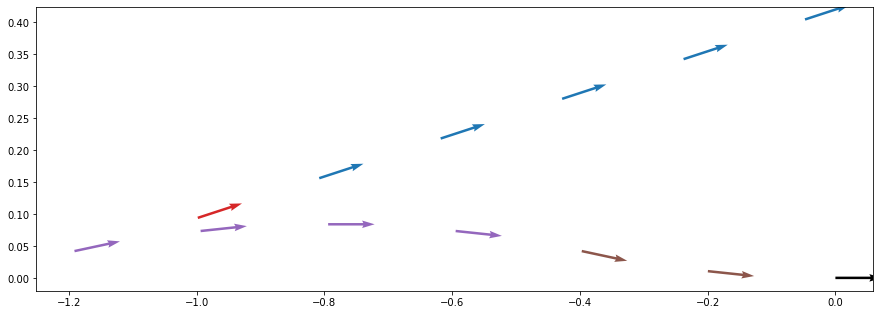

In [317]:
debut = time.time()
(resultat, nombre_iterations, pointsAChercher, pointsDejaCherchés, temps) = chercherMeilleureManoeuvre(PointAngle(0, 0.5, 0),
                               fonctionButAtteint = butAtteint,
                               fonctionHeuristique = heuristique, 
                               pas = 0.2,
                               rayonBraquage = 1.90,
                               toleranceXY = pas * 1.2,
                               toleranceAngle = 20/180*math.pi,
                               limite = 2000,
                               log = False)
fin = time.time()

print(nombre_iterations)
print( fin -debut)
print("temps par iteration " + str(  (fin - debut) / (nombre_iterations+0.00001) * 1000) + " ms")
print(temps)
if resultat != None:
    print(resultat)
    afficherResultat(resultat)
else:
    plt.figure(figsize=(10,10))
    plt.gca().set_aspect('equal', adjustable='box')
    for pa in pointsDejaCherchés:
        afficherResultat(pa, plusieurs = True)

# Conclusion heuristique meilleure distance

ça change très peu la rapidité :-/